# Project Proposal

# *insert title*

## Introduction

### Background Information and Question
When a supergiant star (a highly luminous type of star) dies and collapses in an event called a supernova, its proton and electron located in the star's core merge and create neutrons and ultimately form neutron stars. A particular type of neutron star, pulsars, emit two beams of electromagnetic radiation from two magnetic poles and rotate quickly in a way that the the radio emissions patterns are detectable on Earth.

Pulsars are very important tools used by astronomers. Due to a pulsar's consistent radio emmisions in time, astronomers are able to estimate distances of various cosmic objects using the distance of pulsar and time it takes the radio waves to reach Earth. Additionally, since pulsars are a type of neutron star, astronmers study the inside of the pulsars, especially the obscure state of matter every neutron star contains.

Although every pulsar produces a unique radio emission pattern that slightly changes per rotation. Possible pulsars signals known as "candidates" are averaged over many rotations in order to determine whether the signal is a real pulsar or not. Unfortunately, many false signals are picked up from unwanted radio frequency interference and other noise, resulting in difficulty in identifying pulsars. 

The question that we are asking: Is the radio signal detected that is quantified by the integrated profile and DM-SNR curve a potential pulsar star candidate or not? 




### Dataset used
The dataset that will be used is the Pulsar Star dataset, which can be found [here](https://archive.ics.uci.edu/ml/datasets/HTRU2#). This dataset describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey, an all-sky survey for pulsars and short-duration radio transients.

A candidate is a potential signal detection that may describe a real pulsar and each row of this dataset is a candidate observation. Each column is a variable and there are 9 variables. The first 8 variables are the mean, standard deviation, excess kurtosis, and skewness, of the integrated pulse profile and of the the DM-SNR curve. 

Since pulsars are weak radio sources, many inidividual pulses must be summed to produce a signal that is distinguishable from noise and the detection of the pulsar can be made. The signal resulted from this sum of pulses is called the integrated pulse profile and it is similar to a pulsar's "fingerprint".

!!!The Dispersion Measure/Signal-to-Noise Ratio (DM/SNR) is a measure that compares the level of a desired signal and the level of background noise.

The last variable is the class label. It is 1 if the candidate is a real pulsar and 0 otherwise.

## Preliminary Data Analysis

In [78]:
set.seed(2000)
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)


In [79]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
pulsar_file <- unz(temp, "HTRU_2.csv")
pulsar <- read_csv(pulsar_file, col_names = FALSE)


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



In [80]:
colnames(pulsar) <- c("mean_ip", "std_ip", "kurt_ip", "skew_ip", "mean_dm_snr", "std_dm_snr", "kurt_dm_snr", "skew_dm_snr", "class")

pulsar_mutate <- pulsar %>%
                mutate(class = as_factor(class))
pulsar_mutate

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [81]:
pulsar_split <- initial_split(pulsar_mutate, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split) 
pulsar_test <- testing(pulsar_split)

In [82]:
pulsar_train_scaled <- pulsar_train %>% 
 mutate(scaled_mean_ip = scale(mean_ip, center = TRUE), 
        scaled_std_ip = scale(std_ip, center = TRUE), 
        scaled_kurt_ip = scale(kurt_ip, center = TRUE), 
        scaled_skew_ip = scale(skew_ip, center = TRUE), 
        scaled_mean_dm_snr = scale(mean_dm_snr, center = TRUE), 
        scaled_std_dm_snr = scale(std_dm_snr, center = TRUE), 
        scaled_kurt_dm_snr = scale(kurt_dm_snr, center = TRUE), 
        scaled_skew_dm_snr = scale(skew_dm_snr, center = TRUE))
pulsar_train_scaled

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class,scaled_mean_ip,scaled_std_ip,scaled_kurt_ip,scaled_skew_ip,scaled_mean_dm_snr,scaled_std_dm_snr,scaled_kurt_dm_snr,scaled_skew_dm_snr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
140.5625,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0,1.1417891,1.337348,-0.667846,-0.4040470,-0.3222267,-0.3767276,-0.0630455,-0.2808458
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0,-0.3095702,-1.044136,-0.148401,-0.1218312,-0.3248851,-0.2418872,-0.1163356,-0.3855318
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0,0.9944184,1.555161,-0.513142,-0.3938258,-0.3072380,-0.2820893,-0.3029264,-0.4761081
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.4097,44.62689,2.945244,8.297092,0,0.4457044,0.4341085,-0.3302862,-0.2391952,0.1245798,0.9293977,-1.181334,-0.9044531
119.3359,59.93594,0.1593631,-0.74302540,21.4306,58.87200,2.499517,4.595173,0,0.3212849,1.9570008,-0.3010645,-0.4110390,0.2944053,1.6585698,-1.280424,-0.9394601
57.0625,85.79734,1.4063910,0.08951971,188.3060,64.71256,-1.597527,1.429475,0,-2.0858697,5.7256964,0.8600086,-0.2768400,5.9387487,1.9575338,-2.191242,-0.9693964


In [83]:
sum(is.na(pulsar_train)) #checking for missing values in training data 

[1] 0

In [84]:
#pulsar observation counts with 0's and 1's
count_train_pulsar <- pulsar_train %>%
    group_by(class) %>%
    summarize(n = n())
count_train_pulsar

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12169
1,1255


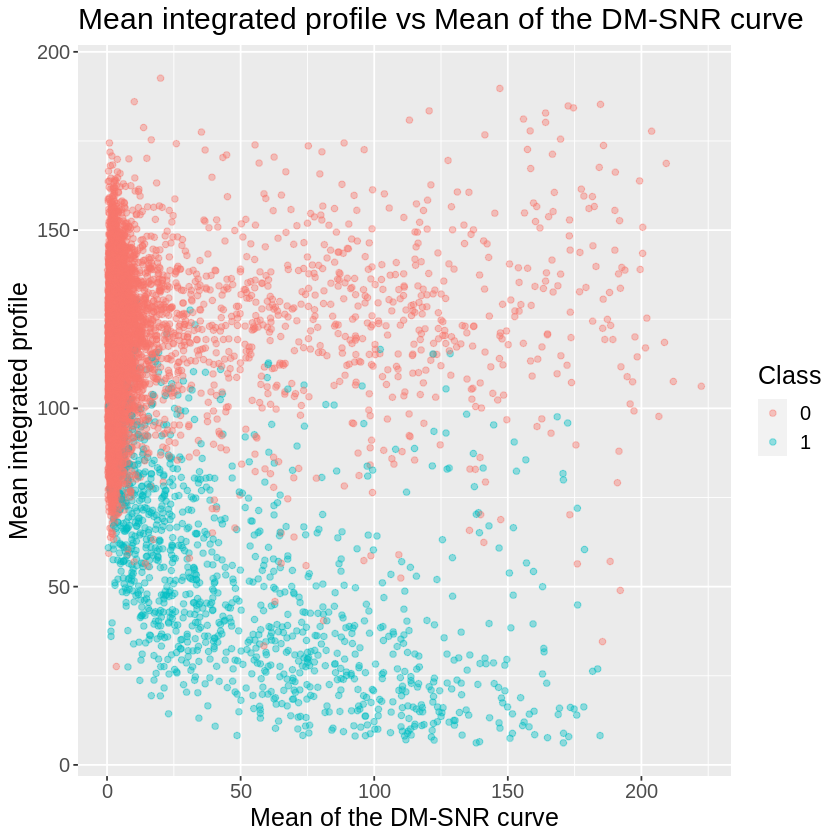

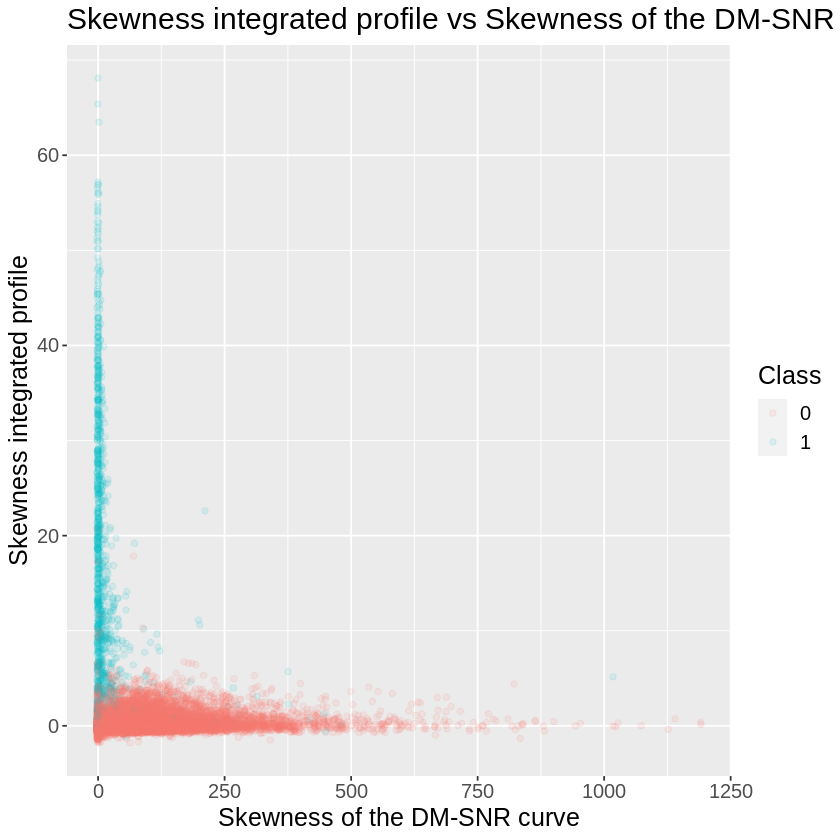

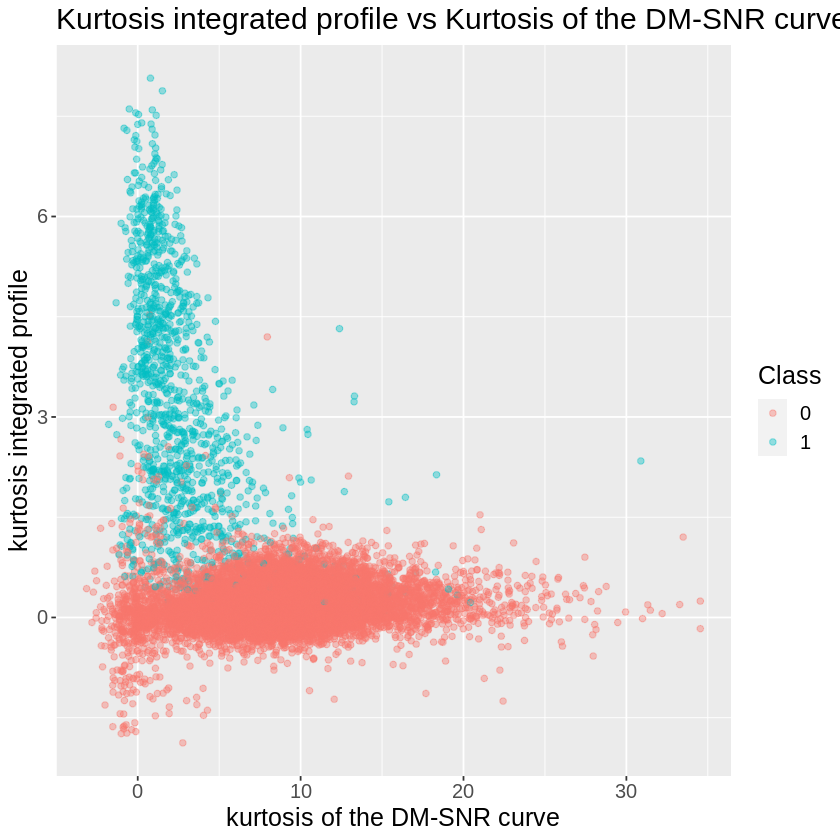

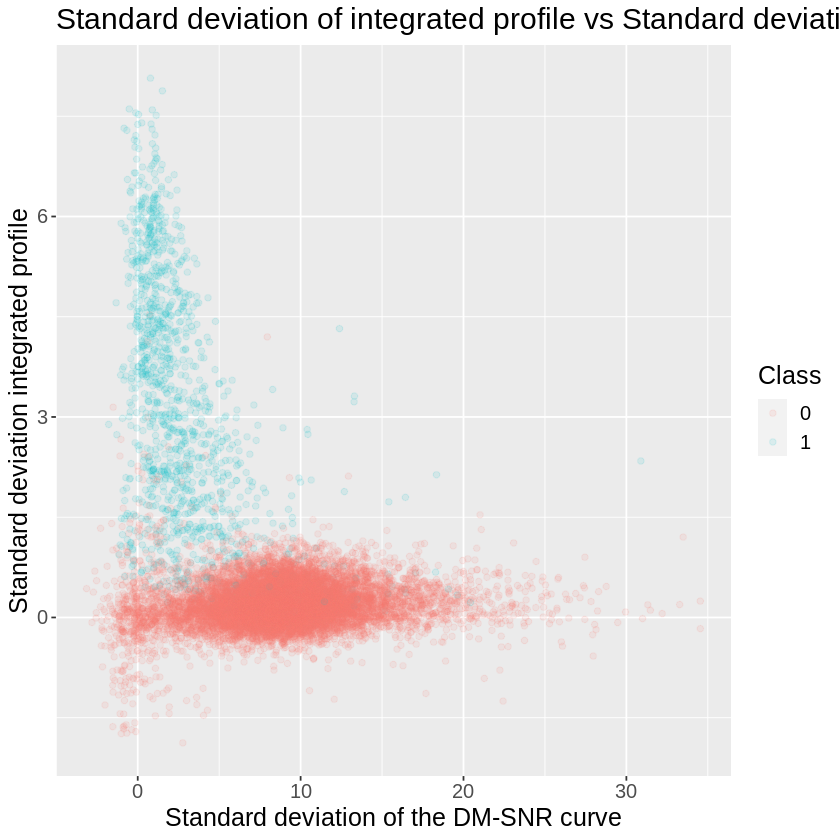

In [85]:
plot_mean_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = mean_dm_snr, y =mean_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "Mean of the DM-SNR curve", y = "Mean integrated profile", color = "Class") +
                theme(text = element_text(size = 15)) +
                ggtitle("Mean integrated profile vs Mean of the DM-SNR curve") 
plot_mean_ip_dmsnr

plot_skew_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = skew_dm_snr, y= skew_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Skewness of the DM-SNR curve", y = "Skewness integrated profile", color = "Class") +
                theme(text = element_text(size = 15)) +
                ggtitle("Skewness integrated profile vs Skewness of the DM-SNR curve") 
plot_skew_ip_dmsnr

plot_kurt_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "kurtosis of the DM-SNR curve", y = "kurtosis integrated profile", color = "Class") +
                theme(text = element_text(size = 15)) +
                ggtitle("Kurtosis integrated profile vs Kurtosis of the DM-SNR curve") 
plot_kurt_ip_dmsnr

plot_std_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Standard deviation of the DM-SNR curve", y = "Standard deviation integrated profile", color = "Class") +
                theme(text = element_text(size = 15)) +
                ggtitle("Standard deviation of integrated profile vs Standard deviation of the DM-SNR curve") 
plot_std_ip_dmsnr

## Methods

We first loaded the dataset and added column names, and changed class into a fct instead of a dbl since this is the binary variable that we are trying to predict for. We will be likely using all of the variables since we only have 8 continuous variables to start with and we will try to visualize the relationship using a scatterplot between each of those variables and whether they all contribute equally to whether a signal detected is classified as a pulsar star or not. The scatterplots will have points that are distinguised by different colours represented its class, allowing us to see which variable combinations (i.e. integrated profile mean and DM-SNR curve mean) may be a potential indicator or a defining characteristic of potential pulsar candidates. Each scatterplot will have an x-axis with DM-SNR (either mean, standard, deviation, excess kurtosis, or skewness) and a y-axis with integrated profile. We will combine DM-SNR mean and integrated profile mean onto one graph and doing the same with all the others. We will use the K-nearest neighbor classification and cross-validation to determine the k that we will use, we intend to use 5 folds to tune the model and maximize the accuracy of our model, this process will be done with all eight continuous variables outlined below. 

The eight continuous variables that we will be using are are the mean, standard deviation, excess kurtosis, and skewness, of the integrated pulse profile and of the the DM-SNR curve. These correspond to the column names mean_ip, std_ip, kurt_ip, skew_ip, mean_dm_snr, std_dm_snr, kurt_dm_snr, skew_dm_snr; and what we are trying to predict for is class. 

## Expected Outcomes and Significance

####  What do you expect to find?
- we expect to find a relationship between the integrated profile and pulsar star candidates as well as a relationship between the DM-SNR curve and pulsar star candiadates. 
- the properties (i.e. mean, standard deviation, skewness etc.) of the integrated profile and DM-SNR curve generated for each star or detected emission pattern would likely be able to predict whether the emission detected is one from a pulsar star or not. 

** be more specific, i.e given these set of characteristics, this is what i expect to find

#### What impact could such findings have? 

- the findings from this project can help with the quick identification of pulsar star candidates which are incredibly important in the scientific study of extreme states of matter, exploration of planets beyond the solar system, in the measurement of distances in space, and potentially even in the study of blackholes. 
- by being able to use certain characteristics to predict or classify a detected emission as potentially being a pulsar star with a high estimation accuracy, this will allow scientists and astronomers to quickly identify pulsar star candidates with relative confidence and save them time from not having to do in depth and long-winded classification procedures for every single emission - allowing more time to be spent on the actual study of for example the solar system. The model that we create and the findings that will be created will be able to act as a sort of vetting process for pulsar star candidates to allow researchers to work more efficiently.  

#### What future questions could this lead to?


- why do pulsar stars have those predictor variable characteristics?
- since the predictor variables explored are continuous numeric values, are there any thresholds for each variable that determine if a star is potentially pulsar or not? Are there specific characteristics that have to be fulfilled in order for a star to be classified as pulsar?